# 📍 01 - Preprocessing Real Crime Data (Chicago)

This notebook focuses on loading and preprocessing real crime data from the city of **Chicago**. The main goal is to transform the raw dataset into a structured format that can be integrated with our **uncertainty-aware hotspot prediction framework**.

We perform the following tasks:

- Load and filter the original crime dataset (e.g., by year or crime types).
- Perform basic exploratory data analysis (EDA) to understand spatial and temporal distributions.
- Map spatial identifiers (e.g., `Beat`) to a regular grid structure.
- Generate a spatio-temporal matrix format compatible with later prediction and evaluation steps.

This step ensures real-world data can be used in a comparable way to our synthetic experiments.


# 📁 Step 1: Load Raw Dataset and Geometry

In this step, we load the raw crime dataset along with the spatial geometry file containing Chicago's police beats.

📦 **Expected data location:**

```
../uncertainty-informed-data/real_data/Chicago
```

We use a **lightweight version** of the dataset, filtered by year or crime types, to speed up experimentation and testing during model development.

The loaded data includes:
- Crime incident records with timestamp and location.
- A shapefile representing spatial units (`Beat`) for aggregation and spatial referencing.


In [21]:
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# Define path
data_path = "../../../../../uncertainty-informed-data/real_data/Chicago"
file_name = "crimes_2024.csv"
file_path = os.path.join(data_path, file_name)

geometry_name = "police_beats.geojson"
geometry_path = os.path.join(data_path, geometry_name)

# Load data
df_raw = pd.read_csv(os.path.abspath(file_path), dtype={"beat": str})
df_raw.head()

gdf = gpd.read_file(os.path.abspath(geometry_path))

# 🔍 Step 2: Initial Inspection

We perform an initial exploration of the raw dataset to understand its structure and guide preprocessing:

- Display **column names** and **data types**
- Check for **missing values**
- Identify relevant columns for analysis

In [22]:
# Display column names and types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258403 entries, 0 to 258402
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    258403 non-null  int64  
 1   case_number           258403 non-null  object 
 2   date                  258403 non-null  object 
 3   block                 258403 non-null  object 
 4   iucr                  258403 non-null  object 
 5   primary_type          258403 non-null  object 
 6   description           258403 non-null  object 
 7   location_description  257350 non-null  object 
 8   arrest                258403 non-null  bool   
 9   domestic              258403 non-null  bool   
 10  beat                  258403 non-null  object 
 11  district              258403 non-null  int64  
 12  ward                  258403 non-null  int64  
 13  community_area        258401 non-null  float64
 14  fbi_code              258403 non-null  object 
 15  

In [23]:
# Preview unique crime types
print("Crime types:", df_raw["primary_type"].unique())

# Check for missing values
print("\nMissing values per column:")
print(df_raw.isna().sum())

Crime types: ['BATTERY' 'WEAPONS VIOLATION' 'CRIMINAL DAMAGE' 'CRIMINAL SEXUAL ASSAULT'
 'OFFENSE INVOLVING CHILDREN' 'MOTOR VEHICLE THEFT' 'DECEPTIVE PRACTICE'
 'HOMICIDE' 'OTHER OFFENSE' 'THEFT' 'ROBBERY'
 'INTERFERENCE WITH PUBLIC OFFICER' 'BURGLARY' 'ASSAULT' 'SEX OFFENSE'
 'NARCOTICS' 'ARSON' 'PUBLIC PEACE VIOLATION' 'CRIMINAL TRESPASS'
 'STALKING' 'INTIMIDATION' 'OBSCENITY' 'PROSTITUTION'
 'CONCEALED CARRY LICENSE VIOLATION' 'KIDNAPPING' 'LIQUOR LAW VIOLATION'
 'GAMBLING' 'PUBLIC INDECENCY' 'OTHER NARCOTIC VIOLATION' 'NON-CRIMINAL'
 'HUMAN TRAFFICKING']

Missing values per column:
id                         0
case_number                0
date                       0
block                      0
iucr                       0
primary_type               0
description                0
location_description    1053
arrest                     0
domestic                   0
beat                       0
district                   0
ward                       0
community_area             2


# 🗺️ Step 3: Visualize Police Beats

We load and visualize the geographical boundaries of **Chicago Police Beats**, which serve as spatial units for aggregation.


Count:  277
Km2 Average:  3.9632404284369396


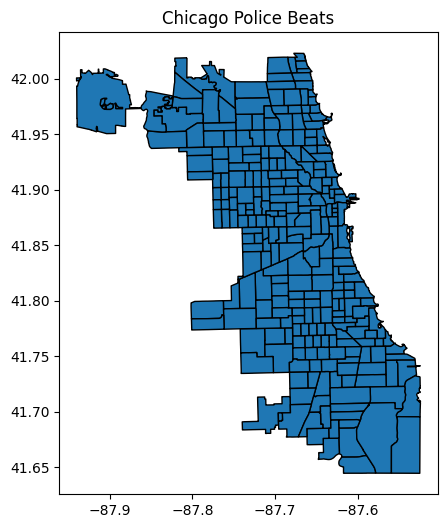

In [24]:
gdf.plot(figsize=(8, 6), edgecolor="black")
print("Count: ",len(gdf))
print("Km2 Average: ",(gdf.to_crs("EPSG:3857").area/(10**6)).mean())

plt.title("Chicago Police Beats")
plt.show()

# 🧼 Step 4: Filter and Clean Columns

We retain only the essential columns required for our spatial-temporal crime modeling pipeline:

- `date`: Timestamp of the crime  
- `latitude`, `longitude`: Spatial coordinates  
- `Beat`: Police unit identifier for spatial aggregation  
- `Primary Type`: Category of the crime  
- `Location Description`: Contextual location (e.g., street, residence)  
- `Year`: To validate and subset time periods

This step reduces dataset size and focuses the analysis on variables relevant for predictive modeling.

In [25]:
df_raw.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [26]:
# We drop rows with missing values in the selected columns and keep only the relevant subset:
keep_cols = ["date", "beat", "latitude", "longitude", "primary_type", "location_description", "year"]
df_filtered = df_raw[keep_cols].dropna()
df_filtered.head()


,date,beat,latitude,longitude,primary_type,location_description,year
0,2024-02-10T00:44:00.000,0925,41.809125,-87.631907,BATTERY,CTA PLATFORM,2024
1,2024-02-22T00:49:00.000,0922,41.812809,-87.704160,BATTERY,SIDEWALK,2024
2,2024-04-09T21:54:00.000,0825,41.776753,-87.682222,WEAPONS VIOLATION,SIDEWALK,2024
3,2024-01-11T08:00:00.000,1512,41.886179,-87.769967,CRIMINAL DAMAGE,STREET,2024
4,2024-02-18T02:00:00.000,0624,41.752006,-87.612523,CRIMINAL SEXUAL ASSAULT,RESIDENCE,2024


In [27]:
# We inspect the data types and confirm there are no remaining missing values after filtering:

print("\nData Types:")
print(df_filtered.dtypes)

print("\nMissing Values:")
print(df_filtered.isna().sum())



Data Types:
date                     object
beat                     object
latitude                float64
longitude               float64
primary_type             object
location_description     object
year                      int64
dtype: object

Missing Values:
date                    0
beat                    0
latitude                0
longitude               0
primary_type            0
location_description    0
year                    0
dtype: int64


# 📆 Step 5: Date Conversion and Day Extraction

We convert the `Date` column to a proper datetime format and extract the day component for temporal grouping. Rows with invalid dates are dropped.

In [28]:
df_filtered["Date"] = pd.to_datetime(df_filtered["date"], errors="coerce")
print("No Date :", df_filtered["Date"].isna().sum())
df_filtered = df_filtered.dropna(subset=["Date"])
df_filtered["Day"] = df_filtered["Date"].dt.date

df_filtered.head()

No Date : 0


,date,beat,latitude,longitude,primary_type,location_description,year,Date,Day
0,2024-02-10T00:44:00.000,0925,41.809125,-87.631907,BATTERY,CTA PLATFORM,2024,2024-02-10 00:44:00,2024-02-10
1,2024-02-22T00:49:00.000,0922,41.812809,-87.704160,BATTERY,SIDEWALK,2024,2024-02-22 00:49:00,2024-02-22
2,2024-04-09T21:54:00.000,0825,41.776753,-87.682222,WEAPONS VIOLATION,SIDEWALK,2024,2024-04-09 21:54:00,2024-04-09
3,2024-01-11T08:00:00.000,1512,41.886179,-87.769967,CRIMINAL DAMAGE,STREET,2024,2024-01-11 08:00:00,2024-01-11
4,2024-02-18T02:00:00.000,0624,41.752006,-87.612523,CRIMINAL SEXUAL ASSAULT,RESIDENCE,2024,2024-02-18 02:00:00,2024-02-18


# 📅 Step 6: Year Verification

We verify that the dataset includes only data from the intended year (2014), which was selected during the download process.

In [29]:
print("\nUnique years:", df_filtered["year"].unique())
if(df_filtered["year"].nunique() == 1 and df_filtered["year"].iloc[0] == 2024): 
    print("✅ Only 2024 data is present.")
else:
    print("⚠️ Data contains other years!")


Unique years: [2024]
✅ Only 2024 data is present.


# 🔎 Step 7: Beat Consistency Check

We check for consistency between the beat identifiers used in the spatial geometry (`gdf`) and those present in the crime dataset (`df_filtered`). This step ensures that spatial joins and aggregations can be performed reliably later.


In [30]:
print(gdf.beat_num.dtype, df_filtered["beat"].dtype)
print(gdf.beat_num.nunique(), df_filtered["beat"].nunique())

print("Beats in geometry but not in crime data:")
print(set(gdf.beat_num.unique()) - set(df_filtered["beat"].unique()))

print("Beats in crime data but not in geometry:")
print(set(df_filtered["beat"].unique()) - set(gdf.beat_num.unique()))

object object
275 275
Beats in geometry but not in crime data:
{'3100'}
Beats in crime data but not in geometry:
{'1650'}


# 📊 Step 8: Distribution of Crime Types and Locations

We visualize the most frequent types of crimes and the most common locations where they occur. This helps us understand the nature of the data and may inform later modeling decisions (e.g., selecting subsets of crimes for focused analysis).


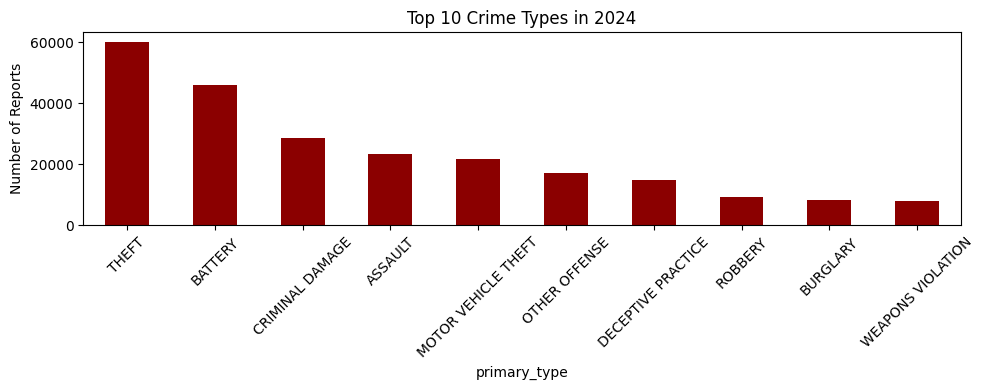

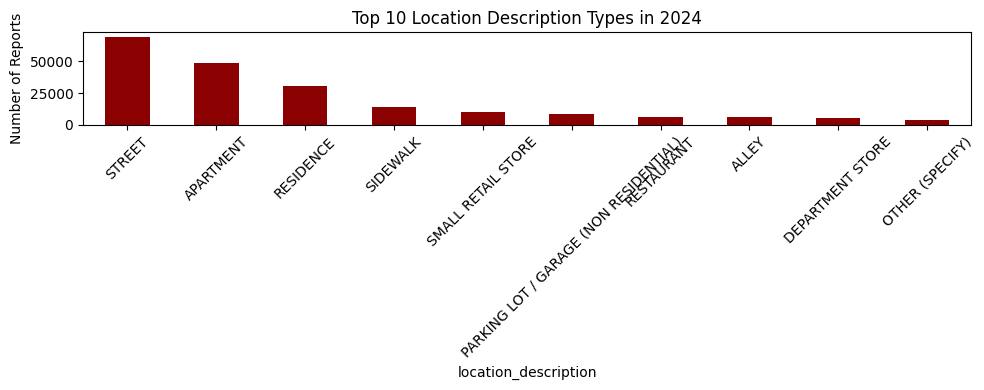

In [34]:
import seaborn as sns

# Top crime types
plt.figure(figsize=(10, 4))
df_filtered["primary_type"].value_counts().head(10).plot(kind="bar", color="darkred")
plt.title("Top 10 Crime Types in 2024")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top Location Description types
plt.figure(figsize=(10, 4))
df_filtered["location_description"].value_counts().head(10).plot(kind="bar", color="darkred")
plt.title("Top 10 Location Description Types in 2024")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📈 Step 9: Temporal Evolution of Crime Counts

We group crimes by date, beat, and type to visualize the temporal dynamics of criminal activity throughout the year. This gives us a sense of fluctuations, trends, and seasonality in the dataset.


<Axes: xlabel='Day', ylabel='count'>

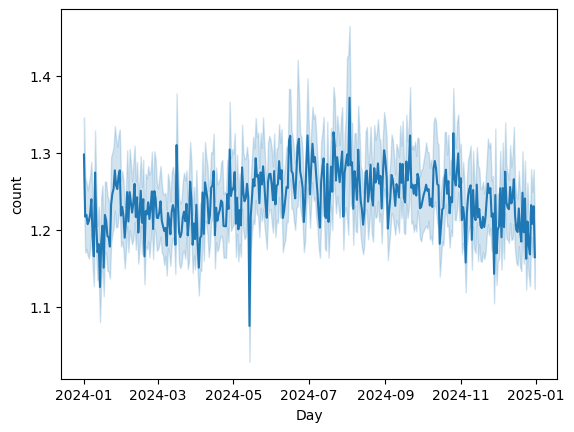

In [38]:
df = df_filtered.groupby(["beat", "primary_type", "Day"]) \
                .agg({"year": "count"}) \
                .reset_index() \
                .rename(columns={"year": "count"})

sns.lineplot(x="Day", y="count", data=df,errorbar='ci')

# 🔍 Crime Type Selection for Hotspot Modeling

To build a meaningful and robust experiment for hotspot prediction under uncertainty, we focus on crime types that:

1. **Occur frequently** – ensuring enough data to model temporal and spatial patterns.
2. **Have operational relevance** – likely to trigger police response or resource allocation.
3. **Are spatially well-defined** – typically happening in public or geographically identifiable places.

---

#### ✅ Recommended Crime Types

These crime types meet the above criteria and are suitable for our initial experiments:

| Crime Type             | Justification                                                  |
|------------------------|----------------------------------------------------------------|
| `BATTERY`              | High frequency, direct impact on public safety                 |
| `ASSAULT`              | Similar to battery, often linked to violent incidents          |
| `ROBBERY`              | Clear hotspots, spatial clustering, operational relevance      |
| `BURGLARY`             | Property crime, location-dependent patterns                    |
| `THEFT`                | Very common, useful to test models on frequent crimes          |
| `MOTOR VEHICLE THEFT`  | Spatially focused, relevant to urban crime trends              |
| `NARCOTICS`            | Known to form persistent hotspots, repetitive spatial patterns |

You may treat them individually or combine them into broader categories such as:

- **Violent Crimes**: `BATTERY`, `ASSAULT`, `ROBBERY`
- **Property Crimes**: `BURGLARY`, `THEFT`, `MOTOR VEHICLE THEFT`


In [39]:
selected_types = [
    "BATTERY", "ASSAULT", "ROBBERY", "BURGLARY",
    "MOTOR VEHICLE THEFT", "THEFT", "NARCOTICS"
]

df=df[df["primary_type"].isin(selected_types)]
df

,beat,primary_type,Day,count
1,0111,ASSAULT,2024-01-03,1
2,0111,ASSAULT,2024-01-05,1
3,0111,ASSAULT,2024-01-17,1
4,0111,ASSAULT,2024-01-24,1
5,0111,ASSAULT,2024-01-25,2
...,...,...,...,...
206383,2535,THEFT,2024-12-25,1
206384,2535,THEFT,2024-12-27,2
206385,2535,THEFT,2024-12-28,3
206386,2535,THEFT,2024-12-29,1


# 📈 Step 10: Daily Crime Trends by Type

We visualize the temporal distribution of the selected crime types to explore their daily activity over the year. This helps identify:

- Temporal seasonality or cycles (e.g., weekdays vs weekends)
- Potential bursts or drops
- Differences in reporting frequency between crime types


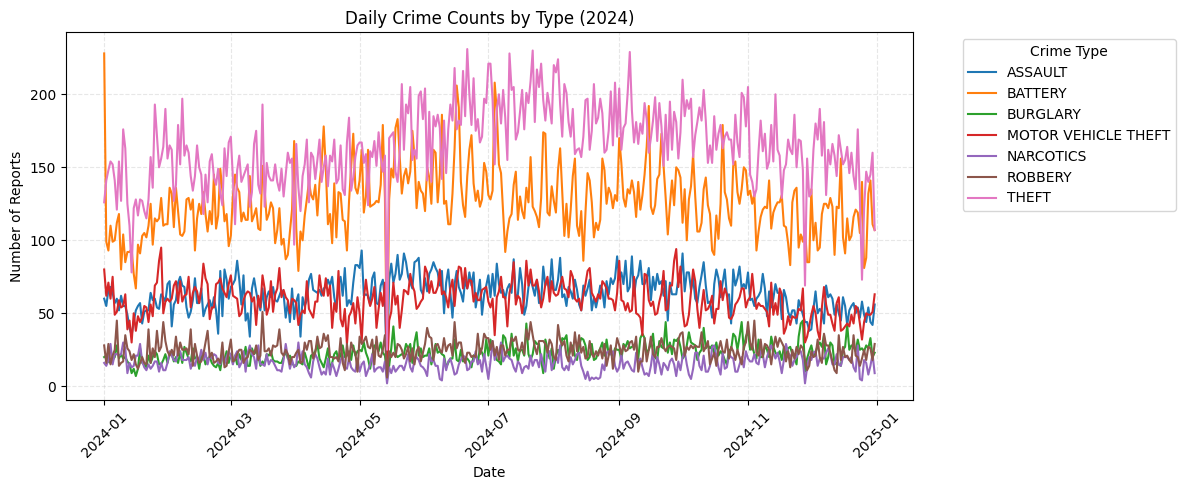

In [40]:
df_day_type = df.groupby(["Day", "primary_type"]).agg({"count": "sum"}).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(
    x="Day", y="count", hue="primary_type",
    data=df_day_type, marker="", errorbar=None
)
plt.title("Daily Crime Counts by Type (2024)")
plt.xlabel("Date")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# 🗺️ Step 11: Spatial Distribution of Crimes by Beat
We visualize the cumulative number of reported crimes in 2024 for selected types: ASSAULT, ROBBERY, and BURGLARY. Each map shows the count aggregated by police beat.

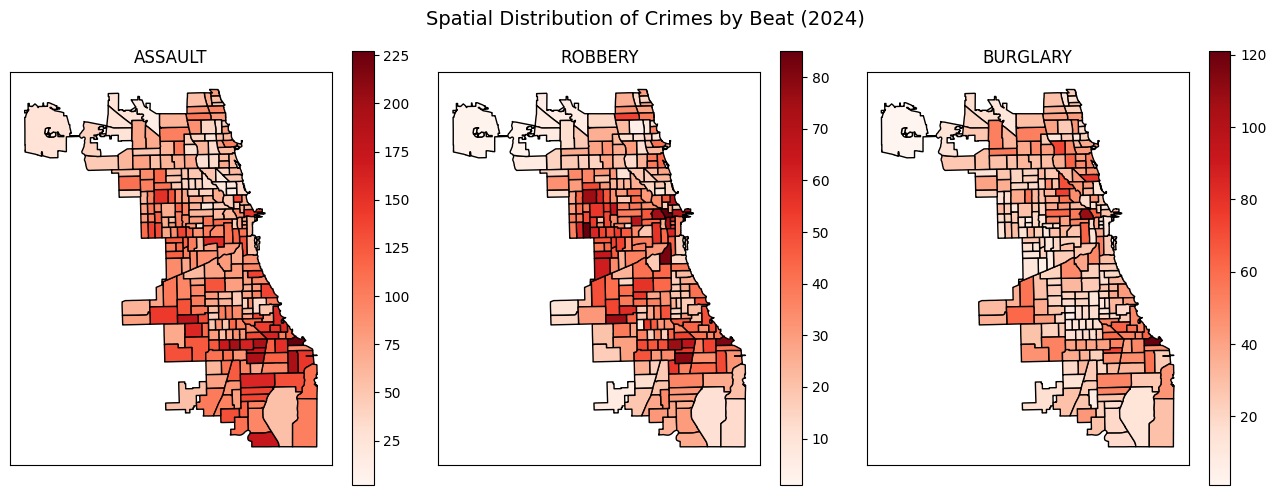

In [42]:

crime_types = ["ASSAULT", "ROBBERY", "BURGLARY"]

fig, axes = plt.subplots(1, 3, figsize=(13, 5), sharex=True, sharey=True)

for ax, crime in zip(axes, crime_types):
    df_crime = df[df["primary_type"] == crime].groupby(["beat"]).agg({"count": "sum"}).reset_index()
    gdf_plot = gdf[["beat_num", "geometry"]].merge(df_crime, how="left", left_on="beat_num", right_on="beat")
    gdf_plot.plot(column="count", cmap="Reds", legend=True, ax=ax, edgecolor="black")
    ax.set_title(f"{crime}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Spatial Distribution of Crimes by Beat (2024)", fontsize=14)
plt.tight_layout()
plt.show()


# ⚙️ Spatial Grid Mapping and Time Formatting Utilities

These helper functions are tailored for processing real crime data from Chicago. They enable integration with the synthetic data pipeline by converting the police beat codes into spatial grid coordinates and computing temporal indices from daily records.

In [48]:
import pandas as pd
import numpy as np

def create_beat_grid_mapping(unique_beats, grid_size=None, seed=42):
    """
    Assign each unique Beat to a (row, col) coordinate on a grid.

    Parameters:
    - unique_beats: list or array of unique beat codes
    - grid_size: tuple (rows, cols). If None, uses smallest square grid.
    - seed: for reproducibility in sorting

    Returns:
    - dict mapping {beat_code: (row, col)}
    """
    np.random.seed(seed)
    beats_sorted = sorted(unique_beats)
    n = len(beats_sorted)

    if grid_size is None:
        side = int(np.ceil(np.sqrt(n)))
        grid_size = (side, side)

    rows, cols = grid_size
    if rows * cols < n:
        raise ValueError("Grid size too small for number of beats.")

    mapping = {}
    for i, beat in enumerate(beats_sorted):
        r = i // cols
        c = i % cols
        mapping[beat] = (r, c)

    return mapping

def prepare_real_crime_dataframe(df_raw, beat_to_coord_map, start_date=None, freq='D'):
    """
    Converts raw real crime data into a long-format dataframe compatible with the synthetic pipeline.

    Parameters:
    - df_raw: pd.DataFrame with columns ['Beat', 'primary_type', 'Day', 'count']
    - beat_to_coord_map: dict mapping Beat ID to (row, col) indices in the spatial grid
    - start_date: str or pd.Timestamp, optional. If given, used to compute time deltas.
    - freq: str, resampling frequency to compute timestep (e.g., 'D' for day)

    Returns:
    - df_formatted: pd.DataFrame with columns ['timestep', 'row', 'col', 'count', 'crime_type']
    """
    df = df_raw.copy()
    df['Day'] = pd.to_datetime(df['Day'])

    if start_date is None:
        start_date = df['Day'].min()

    df['timestep'] = ((df['Day'] - pd.to_datetime(start_date)) / pd.to_timedelta(1, unit=freq)).astype(int)

    df['row'] = df['beat'].map(lambda x: beat_to_coord_map.get(x, (-1, -1))[0])
    df['col'] = df['beat'].map(lambda x: beat_to_coord_map.get(x, (-1, -1))[1])

    df = df[(df['row'] >= 0) & (df['col'] >= 0)]
    df = df.rename(columns={'primary_type': 'crime_type'})

    return df[['timestep', 'row', 'col', 'count', 'crime_type']]


# 💾 Final Processing and Export
We now transform the cleaned crime data into a structured grid-based format compatible with our modeling framework. We also persist the processed data and spatial mapping dictionary for future use.

In [49]:
# Step 1: Assign each Beat to a grid coordinate
unique_beats = sorted(df["beat"].unique())
beat_to_index = create_beat_grid_mapping(unique_beats, grid_size=None, seed=42)

# Step 2: Format into (timestep, row, col, count) structure
R = prepare_real_crime_dataframe(df, beat_to_index, start_date=None, freq='D')

# Step 3: Save processed dataframe to CSV
output_df_path = "../../data/real_data/Chicago/chicago_crime_processed.csv"
R.to_csv(output_df_path, index=False)

# Step 4: Save beat-to-grid mapping as JSON
import json
output_map_path = "../../data/real_data/Chicago/beat_to_coord_map.json"
with open(output_map_path, "w") as f:
    json.dump(beat_to_index, f)

In [50]:
R

,timestep,row,col,count,crime_type
1,2,0,0,1,ASSAULT
2,4,0,0,1,ASSAULT
3,16,0,0,1,ASSAULT
4,23,0,0,1,ASSAULT
5,24,0,0,2,ASSAULT
...,...,...,...,...,...
206383,359,16,2,1,THEFT
206384,361,16,2,2,THEFT
206385,362,16,2,3,THEFT
206386,363,16,2,1,THEFT


In [51]:
R["count"].sum()

np.int64(174679)

In [52]:
R.groupby("crime_type").sum()

,timestep,row,col,count
crime_type,,,,
ASSAULT,3669191,137774,160098,23372
BATTERY,6409071,245966,277742,45945
BURGLARY,1507868,57284,63393,8396
MOTOR VEHICLE THEFT,3295653,127767,150928,21638
NARCOTICS,913205,35109,41928,5957
ROBBERY,1524429,58182,65378,9096
THEFT,7498397,312357,318392,60275


✅ This completes the real data preprocessing. The resulting files can now be used for temporal modeling, visualization, and uncertainty-aware prediction tasks.